In [0]:
!pip install -U tf-nightly

In [0]:
import os
import time

import tensorflow as tf
from tensorflow.contrib import autograph

import matplotlib.pyplot as plt
import numpy as np
import six

from google.colab import widgets

# Case study: training a custom RNN, using Keras and Estimators


In this section, we show how you can use AutoGraph to build RNNColorbot, an RNN that takes as input names of colors and predicts their corresponding RGB tuples. The model will be trained by a [custom Estimator](https://www.tensorflow.org/get_started/custom_estimators).

To get started, set up the dataset. The following cells defines methods that download and format the data needed for RNNColorbot; the details aren't important (read them in the privacy of your own home if you so wish), but make sure to run the cells before proceeding.

In [0]:
def parse(line):
  """Parses a line from the colors dataset."""
  items = tf.string_split([line], ",").values
  rgb = tf.string_to_number(items[1:], out_type=tf.float32) / 255.0
  color_name = items[0]
  chars = tf.one_hot(tf.decode_raw(color_name, tf.uint8), depth=256)
  length = tf.cast(tf.shape(chars)[0], dtype=tf.int64)
  return rgb, chars, length


def set_static_batch_shape(batch_size):
  def apply(rgb, chars, length):
    rgb.set_shape((batch_size, None))
    chars.set_shape((batch_size, None, 256))
    length.set_shape((batch_size,))
    return rgb, chars, length
  return apply


def load_dataset(data_dir, url, batch_size, training=True):
  """Loads the colors data at path into a tf.PaddedDataset."""
  path = tf.keras.utils.get_file(os.path.basename(url), url, cache_dir=data_dir)
  dataset = tf.data.TextLineDataset(path)
  dataset = dataset.skip(1)
  dataset = dataset.map(parse)
  dataset = dataset.cache()
  dataset = dataset.repeat()
  if training:
    dataset = dataset.shuffle(buffer_size=3000)
  dataset = dataset.padded_batch(
      batch_size, padded_shapes=((None,), (None, 256), ()))
  # To simplify the model code, we statically set as many of the shapes that we
  # know.
  dataset = dataset.map(set_static_batch_shape(batch_size))
  return dataset

To show the use of control flow, we write the RNN loop by hand, rather than using a pre-built RNN model.

Note how we write the model code in Eager style, with regular `if` and `while` statements. Then, we annotate the functions with `@autograph.convert` to have them automatically compiled to run in graph mode.
We use Keras to define the model, and we will train it using Estimators.

In [0]:
@autograph.convert()
class RnnColorbot(tf.keras.Model):
  """RNN Colorbot model."""

  def __init__(self):
    super(RnnColorbot, self).__init__()
    self.lower_cell = tf.contrib.rnn.LSTMBlockCell(256, dtype=tf.float32)
    self.upper_cell = tf.contrib.rnn.LSTMBlockCell(128, dtype=tf.float32)
    self.relu_layer = tf.layers.Dense(3, activation=tf.nn.relu)

  def _rnn_layer(self, chars, cell, batch_size, training):
    """A single RNN layer.

    Args:
      chars: A Tensor of shape (max_sequence_length, batch_size, input_size)
      cell: An object of type tf.contrib.rnn.LSTMBlockCell
      batch_size: Int, the batch size to use
      training: Boolean, whether the layer is used for training

    Returns:
      A Tensor of shape (max_sequence_length, batch_size, output_size).
    """
    hidden_outputs = tf.TensorArray(tf.float32, 0, True)
    state, output = cell.zero_state(batch_size, tf.float32)
    for ch in chars:
      cell_output, (state, output) = cell.call(ch, (state, output))
      hidden_outputs.append(cell_output)
    hidden_outputs = autograph.stack(hidden_outputs)
    if training:
      hidden_outputs = tf.nn.dropout(hidden_outputs, 0.5)
    return hidden_outputs

  def build(self, _):
    """Creates the model variables. See keras.Model.build()."""
    self.lower_cell.build(tf.TensorShape((None, 256)))
    self.upper_cell.build(tf.TensorShape((None, 256)))
    self.relu_layer.build(tf.TensorShape((None, 128)))    
    self.built = True


  def call(self, inputs, training=False):
    """The RNN model code. Uses Eager.

    The model consists of two RNN layers (made by lower_cell and upper_cell),
    followed by a fully connected layer with ReLU activation.

    Args:
      inputs: A tuple (chars, length)
      training: Boolean, whether the layer is used for training

    Returns:
      A Tensor of shape (batch_size, 3) - the model predictions.
    """
    chars, length = inputs
    batch_size = chars.shape[0]
    seq = tf.transpose(chars, (1, 0, 2))

    seq = self._rnn_layer(seq, self.lower_cell, batch_size, training)
    seq = self._rnn_layer(seq, self.upper_cell, batch_size, training)

    # Grab just the end-of-sequence from each output.
    indices = (length - 1, list(range(batch_size)))
    indices = tf.stack(indices, 1)
    sequence_ends = tf.gather_nd(seq, indices)
    return self.relu_layer(sequence_ends)

@autograph.convert()
def loss_fn(labels, predictions):
  return tf.reduce_mean((predictions - labels) ** 2)

We will now create the model function for the custom Estimator.

In the model function, we simply use the model class we defined above - that's it!

In [0]:
def model_fn(features, labels, mode, params):
  """Estimator model function."""
  chars = features['chars']
  sequence_length = features['sequence_length']
  inputs = (chars, sequence_length)

  # Create the model. Simply using the AutoGraph-ed class just works!
  colorbot = RnnColorbot()
  colorbot.build(None)

  if mode == tf.estimator.ModeKeys.TRAIN:
    predictions = colorbot(inputs, training=True)
    loss = loss_fn(labels, predictions)

    learning_rate = params['learning_rate']
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    global_step = tf.train.get_global_step()
    train_op = optimizer.minimize(loss, global_step=global_step)
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

  elif mode == tf.estimator.ModeKeys.EVAL:
    predictions = colorbot(inputs)
    loss = loss_fn(labels, predictions)

    return tf.estimator.EstimatorSpec(mode, loss=loss)

  elif mode == tf.estimator.ModeKeys.PREDICT:
    predictions = colorbot(inputs)

    predictions = tf.minimum(predictions, 1.0)
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)

We'll create an input function that will feed our training and eval data.

In [0]:
def input_fn(data_dir, data_url, params, training=True):
  """An input function for training"""
  batch_size = params['batch_size']
  
  # load_dataset defined above
  dataset = load_dataset(data_dir, data_url, batch_size, training=training)

  # Package the pipeline end in a format suitable for the estimator.
  labels, chars, sequence_length = dataset.make_one_shot_iterator().get_next()
  features = {
      'chars': chars,
      'sequence_length': sequence_length
  }

  return features, labels

We now have everything in place to build our custom estimator and use it for training and eval!

In [107]:
params = {
    'batch_size': 64,
    'learning_rate': 0.01,
}

train_url = "https://raw.githubusercontent.com/random-forests/tensorflow-workshop/master/archive/extras/colorbot/data/train.csv"
test_url = "https://raw.githubusercontent.com/random-forests/tensorflow-workshop/master/archive/extras/colorbot/data/test.csv"
data_dir = "tmp/rnn/data"

regressor = tf.estimator.Estimator(
    model_fn=model_fn,
    params=params)

regressor.train(
    input_fn=lambda: input_fn(data_dir, train_url, params),
    steps=100)
eval_results = regressor.evaluate(
    input_fn=lambda: input_fn(data_dir, test_url, params, training=False),
    steps=2
)

print('Eval loss at step %d: %s' % (eval_results['global_step'], eval_results['loss']))

Eval loss at step 100: 0.0705221


And here's the same estimator used for inference.

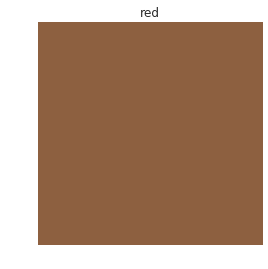

In [108]:
def predict_input_fn(color_name):
  """An input function for prediction."""
  _, chars, sequence_length = parse(color_name)

  # We create a batch of a single element.
  features = {
      'chars': tf.expand_dims(chars, 0),
      'sequence_length': tf.expand_dims(sequence_length, 0)
  }
  return features, None


def draw_prediction(color_name, pred):
  pred = pred * 255
  pred = pred.astype(np.uint8)
  plt.axis('off')
  plt.imshow(pred)
  plt.title(color_name)
  plt.show()


def predict_with_estimator(color_name, regressor):
  predictions = regressor.predict(
      input_fn=lambda:predict_input_fn(color_name))
  pred = next(predictions)
  predictions.close()
  pred = np.minimum(pred, 1.0)
  pred = np.expand_dims(np.expand_dims(pred, 0), 0)

  draw_prediction(color_name, pred)

tb = widgets.TabBar(["RNN Colorbot"])
while True:
  with tb.output_to(0):
    try:
      color_name = six.moves.input("Give me a color name (or press 'enter' to exit): ")
    except (EOFError, KeyboardInterrupt):
      break
  if not color_name:
    break
  with tb.output_to(0):
    tb.clear_tab()
    predict_with_estimator(color_name, regressor)
  